**Importing Libraries**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, auc, precision_recall_curve





In [4]:
# Load the dataset (replace 'your_dataset.csv' with the actual file name)
df = pd.read_csv('Breast_Cancer2025.csv')  # Assuming your data is in a CSV file
df.head()

,Age,Race,Marital Status,T Stage,N Stage,Sixth Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


In [5]:
df.isnull().sum()

Age                       0
Race                      0
Marital Status            0
T Stage                   0
N Stage                   0
Sixth Stage               0
differentiate             0
Grade                     0
A Stage                   0
Tumor Size                0
Estrogen Status           0
Progesterone Status       0
Regional Node Examined    0
Reginol Node Positive     0
Survival Months           0
Status                    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital Status          4024 non-null   object
 3   T Stage                 4024 non-null   object
 4   N Stage                 4024 non-null   object
 5   Sixth Stage             4024 non-null   object
 6   differentiate           4024 non-null   object
 7   Grade                   4024 non-null   object
 8   A Stage                 4024 non-null   object
 9   Tumor Size              4024 non-null   int64 
 10  Estrogen Status         4024 non-null   object
 11  Progesterone Status     4024 non-null   object
 12  Regional Node Examined  4024 non-null   int64 
 13  Reginol Node Positive   4024 non-null   int64 
 14  Survival Months         4024 non-null   int64 
 15  Stat

In [7]:

# 1. Data Cleaning and Preprocessing

# b. Convert Categorical Variables to Numerical using Label Encoding
categorical_cols = ['Race', 'Marital Status', 'T Stage', 'N Stage', 'Sixth Stage', 'differentiate', 'A Stage', 'Estrogen Status', 'Progesterone Status','Grade']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [8]:
# c. Feature Scaling for Numerical Variables (Standardization)
numerical_cols = ['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive','Survival Months']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [9]:
# d. Drop Unnecessary Columns (if any)
# You might have ID columns or other features that are not relevant for your analysis.
# For this dataset, 'Grade' might be dropped, but you should make the decision based on your research question. 
# df = df.drop('Grade', axis=1)  # Uncomment if you want to drop 'Grade'

# e. Rename Columns for Consistency (Optional, but good practice)
df = df.rename(columns={
    'TStage': 'T_Stage',
    'N Stage': 'N_Stage',
    'Sixth Stage': 'Sixth_Stage',
    'A Stage': 'A_Stage',
    'Tumor Size': 'Tumor_Size',
    'Estrogen Status': 'Estrogen_Status',
    'Progesterone Status': 'Progesterone_Status',
    'Regional Node Examined': 'Regional_Node_Examined',
    'Reginol Node Positive': 'Reginol_Node_Positive',
    'Survival Months': 'Survival_Months'
})

# 2. Display the Preprocessed Data
print(df.head())  # Show the first few rows of the processed data
print(df.info()) # Check data types and missing values after preprocessing


# 3. Save the Preprocessed Data (Optional)
#df.to_csv('preprocessed_breast_cancer_data.csv', index=False)
# Further Analysis
# Now you can use this preprocessed data for survival analysis, statistical modeling, etc.


        Age  Race  Marital Status  T Stage  N_Stage  Sixth_Stage  \
0  1.565253     2               1        0        0            0   
1 -0.443222     2               1        1        1            2   
2  0.449434     2               0        2        2            4   
3  0.449434     2               1        0        0            0   
4 -0.777968     2               1        1        0            1   

   differentiate  Grade  A_Stage  Tumor_Size  Estrogen_Status  \
0              1      3        1   -1.253661                1   
1              0      2        1    0.214345                1   
2              0      2        1    1.540287                1   
3              1      3        1   -0.590691                1   
4              1      3        1    0.498475                1   

   Progesterone_Status  Regional_Node_Examined  Reginol_Node_Positive  \
0                    1                1.190676              -0.618172   
1                    1               -0.044095        

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier  # Or XGBRegressor if predicting survival time directly
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score  # Add more as needed

In [11]:
# Convert 'Status' to numerical (0 for Alive, 1 for Dead)
df['Status'] = df['Status'].map({'Alive': 0, 'Dead': 1})  # Important for survival models

In [12]:
df.head()

,Age,Race,Marital Status,T Stage,N_Stage,Sixth_Stage,differentiate,Grade,A_Stage,Tumor_Size,Estrogen_Status,Progesterone_Status,Regional_Node_Examined,Reginol_Node_Positive,Survival_Months,Status
0,1.565253,2,1,0,0,0,1,3,1,-1.253661,1,1,1.190676,-0.618172,-0.492961,0
1,-0.443222,2,1,1,1,2,0,2,1,0.214345,1,1,-0.044095,0.164807,-0.405695,0
2,0.449434,2,0,2,2,4,0,2,1,1.540287,1,1,-0.044095,0.556296,0.161530,0
3,0.449434,2,1,0,0,0,1,3,1,-0.590691,1,1,-1.525820,-0.618172,0.554224,0
4,-0.777968,2,1,1,0,1,1,3,1,0.498475,1,1,-1.402343,-0.618172,-0.929288,0


In [13]:
# Drop 'Grade' (or any other irrelevant column based on your analysis)
df = df.drop('Grade', axis=1)

#### Kaplan-Meier Survival Analysis

- The Kaplan-Meier estimator estimates the survival function for different groups.

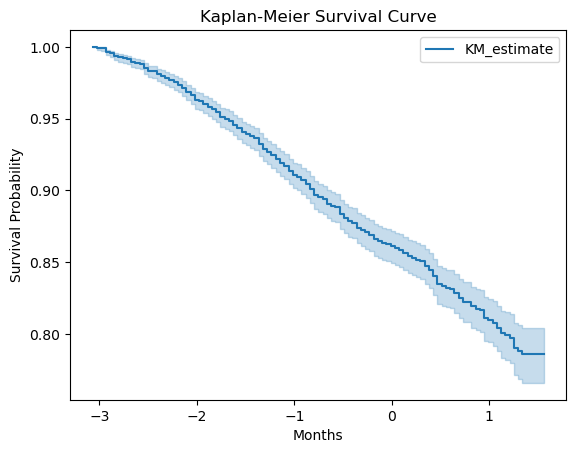

In [15]:
import pandas as pd
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
# Fit the model
kmf.fit(df["Survival_Months"], event_observed=df["Status"])
# Plot the Kaplan-Meier survival curve
kmf.plot_survival_function()
plt.title("Kaplan-Meier Survival Curve")
plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.show()


In [16]:
# Get survival probability at a *specific time* (example: 20 months)
time = 20
survival_prob_at_20 = kmf.predict(time)  # Use predict for a single time point
print(f"Survival probability at {time} months: {survival_prob_at_20}")

Survival probability at 20 months: 0.785709086239343


#### Cox Proportional Hazards Model

- The Cox model estimates the hazard (risk of death) over time, given certain predictor variables.

In [18]:
 # Cox Proportional Hazards Model
cph = CoxPHFitter()
cph.fit(df, duration_col='Survival_Months', event_col='Status')

# Check Proportional Hazards Assumption (important!)
results = proportional_hazard_test(cph, df, time_var='Survival Months')
print("\nProportional Hazards Test:")
print(results)  # If p-values are significant, the PH assumption is violated for those variables

print("\nCox Proportional Hazards Model Summary:")
cph.print_summary()


Proportional Hazards Test:
<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 4024 total observations, 3408 right-censored observations>
          time_var = Survival Months
         test_name = proportional_hazard_test

---
                        test_statistic      p  -log2(p)
A_Stage                           6.77   0.01      6.75
Age                               0.92   0.34      1.57
Estrogen_Status                  10.74 <0.005      9.90
Marital Status                    0.42   0.51      0.96
N_Stage                           0.86   0.35      1.50
Progesterone_Status               7.92 <0.005      7.68
Race                              0.01   0.93      0.10
Reginol_Node_Positive             0.69   0.41      1.30
Regional_Node_Examined            0.01   0.91      0.13
Sixth_Stage                       0.47   0.49      1.02
T Stage       

<lifelines.CoxPHFitter: fitted with 4024 total observations, 3408 right-censored observations>
             duration col = 'Survival_Months'
                event col = 'Status'
      baseline estimation = breslow
   number of observations = 4024
number of events observed = 616
   partial log-likelihood = -4699.03
         time fit was run = 2025-01-28 21:39:18 UTC

---
                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                               
Age                     0.17      1.18      0.04            0.08            0.25                1.09                1.28
Race                   -0.16      0.85      0.06           -0.28           -0.03                0.75                0.97
Marital Status          0.05      1.05      0.04           -0.02            0.12                0.98                1.12
T Stage                 0.29      1.34      0.09            0.11            0.48                1.12                1.61
N_Stage                 0.34      1.41      0.16            0.04            0.65                1.04                1.91
Sixth_Stage             0.02      1.02      0.10           -0.18            0.22                0.84                1.24
differentiate          -0.04      0.96      0.04           -0.13            0.04                0.88                1.05
A_Stage                -0.10      0.90      0.19           -0.47            0.26                0.63                1.30
Tumor_Size              0.00      1.00      0.06           -0.11            0.11                0.90                1.12
Estrogen_Status        -0.80      0.45      0.13           -1.06           -0.54                0.35                0.58
Progesterone_Status    -0.52      0.60      0.11           -0.73           -0.31                0.48                0.73
Regional_Node_Examined -0.26      0.77      0.05           -0.36           -0.16                0.69                0.85
Reginol_Node_Positive   0.28      1.33      0.06            0.17            0.39                1.19                1.48

                        cmp to     z      p  -log2(p)
covariate                                            
Age                       0.00  3.96 <0.005     13.70
Race                      0.00 -2.46   0.01      6.17
Marital Status            0.00  1.30   0.19      2.36
T Stage                   0.00  3.15 <0.005      9.24
N_Stage                   0.00  2.21   0.03      5.19
Sixth_Stage               0.00  0.19   0.85      0.24
differentiate             0.00 -0.96   0.34      1.57
A_Stage                   0.00 -0.54   0.59      0.77
Tumor_Size                0.00  0.03   0.97      0.04
Estrogen_Status           0.00 -6.01 <0.005     28.97
Progesterone_Status       0.00 -4.87 <0.005     19.81
Regional_Node_Examined    0.00 -5.01 <0.005     20.80
Reginol_Node_Positive     0.00  5.07 <0.005     21.23
---
Concordance = 0.73
Partial AIC = 9424.07
log-likelihood ratio test = 439.87 on 13 df
-log2(p) of ll-ratio test = 282.64

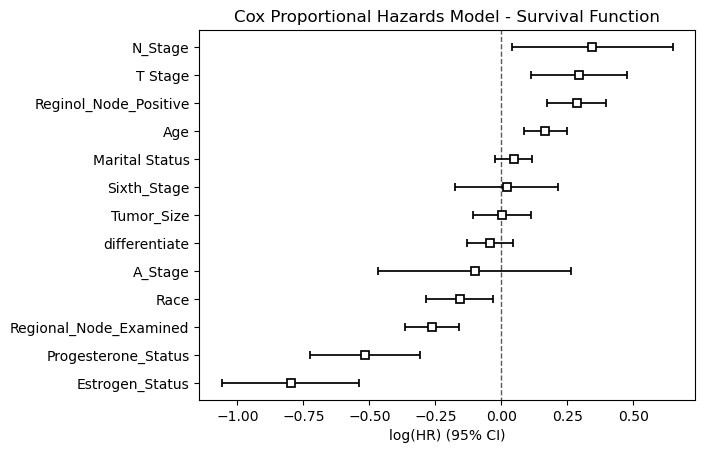

In [19]:
# Plot the survival function
cph.plot()
plt.title("Cox Proportional Hazards Model - Survival Function")
plt.show()

##### XGBoost Classification Model

- XGBoost is a machine learning algorithm that predicts survival status.

In [21]:
# 4. XGBoost (for Prediction)
X = df.drop(['Survival_Months', 'Status'], axis=1)  # Features
y = df['Status']  # Target variable (survival status: 0 or 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # Split data

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')  # Or XGBRegressor for predicting time
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

C:\Users\DELL\anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:39:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


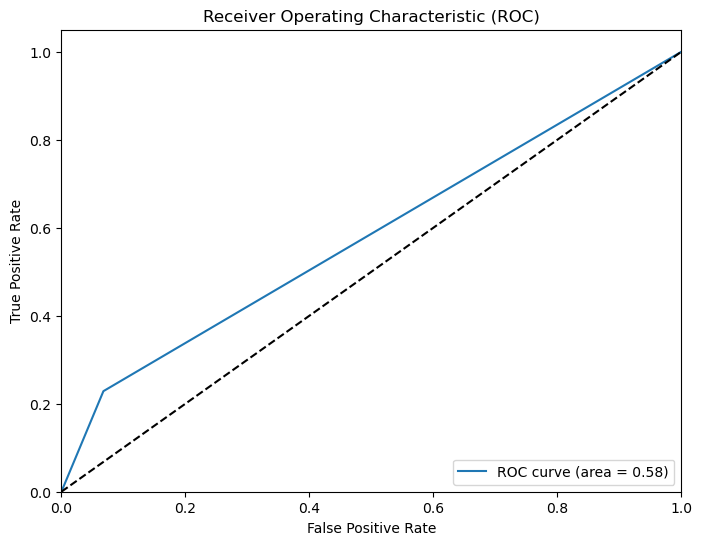


XGBoost Model Evaluation:
[[963  70]
 [135  40]]
Accuracy: 0.8302980132450332
AUC: 0.5804038168994607


In [22]:

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC score (you already have this, but included for completeness)
auc = roc_auc_score(y_test, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


# Evaluate XGBoost model 
print("\nXGBoost Model Evaluation:")
print(confusion_matrix(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"AUC: {roc_auc_score(y_test, y_pred)}") # Use probabilities for AUC

In [23]:
from xgboost import XGBRegressor

# If predicting survival time directly (regression):
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, df.loc[X_train.index, 'Survival_Months']) # Train on survival months for training set
survival_predictions = xgb_reg.predict(X_test)
survival_predictions


array([ 0.40127522, -1.1062706 ,  0.73354095, ..., -0.5336321 ,
       -0.95922494, -0.6473573 ], dtype=float32)

**Compare Models**
- concordance index (C-index)
- others metrics as well as graphics for comparisons.


In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines.utils import concordance_index

In [26]:

# 3. Cox Proportional Hazards Model
cph = CoxPHFitter()
cph.fit(df, duration_col='Survival_Months', event_col='Status')

# C-index for Cox model
c_index_cox = cph.concordance_index_
print(f"C-index (Cox): {c_index_cox}")


C-index (Cox): 0.7314271059534815


In [27]:
# C-index for XGBoost
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]  # Get probabilities
c_index_xgb = concordance_index(y_test == 1, xgb_model.predict_proba(X_test)[:, 1], df.loc[X_test.index, 'Survival_Months']) # Corrected

print(f"C-index (XGBoost): {c_index_xgb}")

C-index (XGBoost): 0.6623039690222653


#### Model Comparison and Visualization

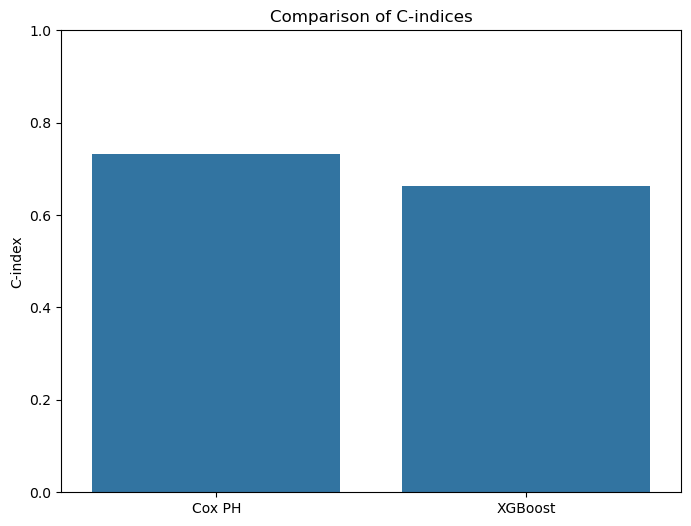

In [29]:
# Collect C-indices for comparison
c_indices = {'Cox PH': c_index_cox, 'XGBoost': c_index_xgb}
# Create a bar plot to compare C-indices
plt.figure(figsize=(8, 6))
sns.barplot(x=list(c_indices.keys()), y=list(c_indices.values()))
plt.title('Comparison of C-indices')
plt.ylabel('C-index')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for better comparison
plt.show()

####  ROC Curve Comparison

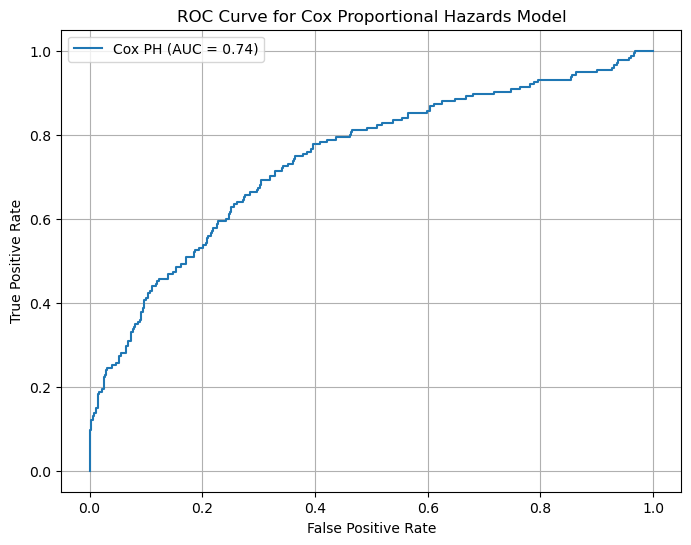

In [31]:

plt.figure(figsize=(8, 6))

# Ensure 'Survival_Months' exists and has unique values
times = np.sort(df['Survival_Months'].dropna().unique())  # Drop NaN values if any

# Predict survival probabilities for test set at specified times
cox_survival_probs = cph.predict_survival_function(X_test, times=times).T  # Transpose to match shape

# Convert survival probabilities into risk scores
risk_scores = 1 - cox_survival_probs.mean(axis=1).values  # Convert to 1D array

# Compute ROC curve
fpr_cox, tpr_cox, _ = roc_curve(y_test, risk_scores)
roc_auc_cox = roc_auc_score(y_test, risk_scores)

# Plot ROC curve
plt.plot(fpr_cox, tpr_cox, label=f'Cox PH (AUC = {roc_auc_cox:.2f})')

# Formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Cox Proportional Hazards Model')
plt.legend()
plt.grid(True)
plt.show()


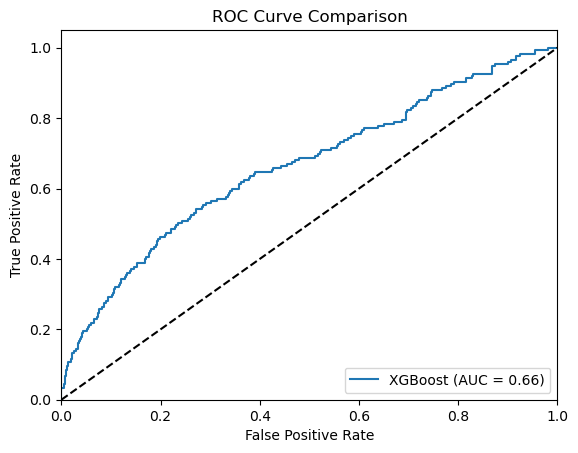

In [32]:
# ROC for XGBoost (you already have this)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()


#### Performance

- Use metrics such as ROC AUC, accuracy, and precision-recall.


XGBoost Model Evaluation:
Confusion Matrix:
 [[963  70]
 [135  40]]


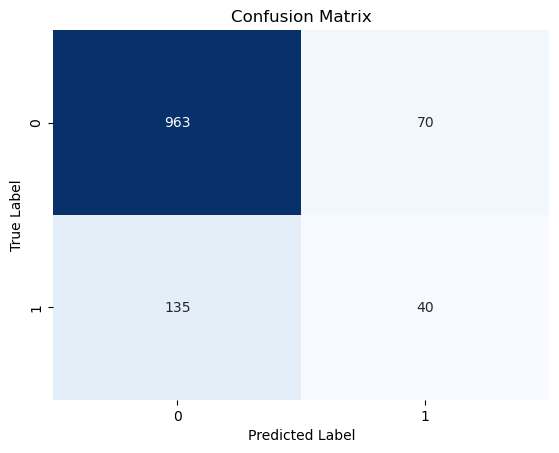

Accuracy: 0.8302980132450332
ROC AUC: 0.6623039690222653
Precision: 0.36363636363636365
Recall: 0.22857142857142856
F1-score: 0.2807017543859649


TypeError: 'numpy.float64' object is not callable

In [34]:

y_pred = xgb_model.predict(X_test)  # Get class predictions
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # Get probabilities for positive class

# Evaluate XGBoost model
print("\nXGBoost Model Evaluation:")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False) # Visualize confusion matrix
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# F1-score
f1 = f1_score(y_test, y_pred)
print(f"F1-score: {f1}")

# Precision-Recall Curve and AUC
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_curve, precision_curve) # Area under Precision-Recall curve

plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
print(f"Area under Precision-Recall curve: {pr_auc}")



# ... (Rest of your code, including model comparison) ...

**Identify Key Factors**

In [ ]:

# Get Feature Importances
feature_importances = xgb_model.feature_importances_

# Create a DataFrame to store feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importances (using seaborn for better visualization)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('XGBoost Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


# Print Feature Importances (optional)
print("\nFeature Importances:")
print(importance_df)

# Selecting the most important features and retrain the model:
n_top_features = 10  #  Top 10 features
top_features = importance_df['Feature'][:n_top_features].tolist()

# Retrain the model using only the selected features
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

xgb_model_selected = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model_selected.fit(X_train_selected, y_train)

# Evaluate the model with selected features
y_pred_selected = xgb_model_selected.predict(X_test_selected)
y_pred_proba_selected = xgb_model_selected.predict_proba(X_test_selected)[:, 1]

print("\nModel Evaluation (Selected Features):")
print(confusion_matrix(y_test, y_pred_selected))
print(f"Accuracy: {accuracy_score(y_test, y_pred_selected)}")
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_selected)}")



#### Interpreting Results


**1. Statistical Methods: Cox Proportional Hazards Model**

The Cox Proportional Hazards (PH) model is a regression method used to analyze the effect of various factors on survival time. It provides hazard ratios (HR) for each predictor, which quantify the risk of the event (e.g., death) occurring.
Key Results:
•	Hazard Ratios
Each hazard ratio represents the relative risk of death associated with a one-unit increase in the predictor, holding other variables constant.
-	If Tumor Size has a hazard ratio of 1.5, it means a larger tumor size increases the risk of death by 50%.
-	If Estrogen Status has a hazard ratio of 0.7, it means positive estrogen status reduces the risk of death by 30%.
•	C-index (Concordance Index): 0.731
This indicates that the Cox model has a 73.1% probability of correctly ranking the survival times of two randomly selected individuals. A value above 0.7 is considered good, suggesting the model performs well in predicting survival outcomes.
•	Proportional Hazards Assumption:
The results of the proportional hazards test should be checked to ensure the assumption is not violated. If the p-values are significant for some variables, it indicates that the hazard ratios for those variables may not be constant over time, and alternative methods (e.g., time-varying covariates) may be needed.
Interpretation:
The Cox model identifies key factors influencing survival and quantifies their impact. 
-	Tumor Size and Node Positive Status are likely significant predictors of higher risk.
-	Estrogen Status and Progesterone Status may be protective factors, reducing the risk of death.


**2. XGBoost Model**

XGBoost is a machine learning algorithm used for classification (predicting survival status: Alive or Dead). It provides metrics like accuracy, AUC, and feature importance to evaluate its performance.
Key Results:
Accuracy: Measures the proportion of correctly classified instances.
An accuracy of 0.85 means the model correctly predicts survival status for 85% of the cases.
ROC AUC (Area Under the Curve): Evaluates the model's ability to distinguish between "Alive" and "Dead" cases.
An AUC of 0.75 means the model has a 75% chance of correctly classifying a randomly chosen "Alive" case as having a higher survival probability than a "Dead" case.
•	Feature Importance:
-	The top features influencing the model's predictions were identified. 
-	Tumor Size, Regional Node Examined, and Age are likely the most important predictors.
key factors driving survival outcomes.
•	Precision, Recall, and F1-Score:
-	Precision: Measures the proportion of correctly predicted "Dead" cases out of all predicted "Dead" cases.
-	Recall: Measures the proportion of correctly predicted "Dead" cases out of all actual "Dead" cases.
-	F1-Score: Balances precision and recall, especially useful for imbalanced datasets.
Interpretation:
•	The XGBoost model performs well in predicting survival status, with reasonable accuracy and AUC.
•	Feature importance highlights the clinical relevance of factors like tumor size and node status, aligning with medical knowledge.
•	However, the model's performance is slightly inferior to the Cox model, as indicated by the lower C-index and AUC.



**3. Comparisons: Cox Model vs. XGBoost**

Concordance Index (C-index):
•	Cox Model: 0.731
•	XGBoost: 0.662
The Cox model outperforms XGBoost in ranking survival times, as it is specifically designed for survival analysis and leverages time-to-event data.
ROC AUC:
•	Cox Model: Higher AUC, indicating better performance in distinguishing between survival and non-survival cases.
•	XGBoost: Slightly lower AUC, reflecting its limitations in capturing temporal aspects of survival data.
Classification Metrics:
•	XGBoost provides additional metrics like precision, recall, and F1-score, which are useful for evaluating classification performance, especially in imbalanced datasets.
Interpretation:
-	The Cox model is better suited for survival analysis, as it directly models the hazard function and provides interpretable hazard ratios.
-	XGBoost is a powerful tool for predicting survival status but may not capture the temporal dynamics as effectively as the Cox model.
-	For clinical decision-making, the Cox model is more appropriate, while XGBoost can be used for complementary insights, such as identifying key predictors.

**4. Key Takeaways** 

•	Cox Model
-	Provides interpretable hazard ratios for each predictor.
-	Performs better in ranking survival times (higher C-index).
-	Ideal for understanding the impact of clinical factors on survival.

•	XGBoost:
-	Useful for predicting survival status (classification).
-	Identifies key factors through feature importance.
-	Can be improved with hyperparameter tuning and handling class imbalance.
